# 论文14：通过联合学习对齐和翻译进行神经机器翻译
## Dzmitry Bahdanau, KyungHyun Cho, Yoshua Bengio (2014)

### 原始注意力机制

这篇论文介绍了**注意力**——深度学习最重要的创新之一。比 Transformer 早了 3 年！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 问题：固定长度上下文向量

传统的 seq2seq 将整个输入压缩为单个向量 → 信息瓶颈！

In [2]:
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class EncoderRNN:
    """Bidirectional RNN encoder"""
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        
        # Forward RNN
        self.W_fwd = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_fwd = np.zeros((hidden_size, 1))
        
        # Backward RNN
        self.W_bwd = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_bwd = np.zeros((hidden_size, 1))
    
    def forward(self, inputs):
        """
        inputs: list of (input_size, 1) vectors
        Returns: list of bidirectional hidden states (2*hidden_size, 1)
        """
        seq_len = len(inputs)
        
        # Forward pass
        h_fwd = []
        h = np.zeros((self.hidden_size, 1))
        for x in inputs:
            concat = np.vstack([x, h])
            h = np.tanh(np.dot(self.W_fwd, concat) + self.b_fwd)
            h_fwd.append(h)
        
        # Backward pass
        h_bwd = []
        h = np.zeros((self.hidden_size, 1))
        for x in reversed(inputs):
            concat = np.vstack([x, h])
            h = np.tanh(np.dot(self.W_bwd, concat) + self.b_bwd)
            h_bwd.append(h)
        h_bwd = list(reversed(h_bwd))
        
        # Concatenate forward and backward
        annotations = [np.vstack([h_f, h_b]) for h_f, h_b in zip(h_fwd, h_bwd)]
        
        return annotations

print("Bidirectional Encoder created")

Bidirectional Encoder created


## Bahdanau 注意力机制

关键创新：联合对齐和翻译！

**注意力分数**：$e_{ij} = a(s_{i-1}, h_j)$，其中 $s$ 是解码器状态，$h$ 是编码器标注

**注意力权重**：$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_k \exp(e_{ik})}$

**上下文向量**：$c_i = \sum_j \alpha_{ij} h_j$

In [3]:
class BahdanauAttention:
    """Additive attention mechanism"""
    def __init__(self, hidden_size, annotation_size):
        self.hidden_size = hidden_size
        
        # Attention parameters
        self.W_a = np.random.randn(hidden_size, hidden_size) * 0.01
        self.U_a = np.random.randn(hidden_size, annotation_size) * 0.01
        self.v_a = np.random.randn(1, hidden_size) * 0.01
    
    def forward(self, decoder_hidden, encoder_annotations):
        """
        decoder_hidden: (hidden_size, 1) - current decoder state s_{i-1}
        encoder_annotations: list of (annotation_size, 1) - all encoder states h_j
        
        Returns:
        context: (annotation_size, 1) - weighted sum of annotations
        attention_weights: (seq_len,) - attention distribution
        """
        scores = []
        
        # Compute attention scores for each position
        for h_j in encoder_annotations:
            # e_ij = v_a^T * tanh(W_a * s_{i-1} + U_a * h_j)
            score = np.dot(self.v_a, np.tanh(
                np.dot(self.W_a, decoder_hidden) + 
                np.dot(self.U_a, h_j)
            ))
            scores.append(score[0, 0])
        
        # Softmax to get attention weights
        scores = np.array(scores)
        attention_weights = softmax(scores)
        
        # Compute context vector as weighted sum
        context = sum(alpha * h for alpha, h in zip(attention_weights, encoder_annotations))
        
        return context, attention_weights

print("Bahdanau Attention mechanism created")

Bahdanau Attention mechanism created


## 带注意力的解码器

In [4]:
class AttentionDecoder:
    """RNN decoder with Bahdanau attention"""
    def __init__(self, output_size, hidden_size, annotation_size):
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Attention mechanism
        self.attention = BahdanauAttention(hidden_size, annotation_size)
        
        # RNN: takes previous output + context
        input_size = output_size + annotation_size
        self.W_dec = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.b_dec = np.zeros((hidden_size, 1))
        
        # Output layer
        self.W_out = np.random.randn(output_size, hidden_size + annotation_size + output_size) * 0.01
        self.b_out = np.zeros((output_size, 1))
    
    def step(self, prev_output, decoder_hidden, encoder_annotations):
        """
        Single decoding step
        
        prev_output: (output_size, 1) - previous output word
        decoder_hidden: (hidden_size, 1) - previous decoder state
        encoder_annotations: list of (annotation_size, 1) - encoder states
        
        Returns:
        output: (output_size, 1) - predicted output distribution
        new_hidden: (hidden_size, 1) - new decoder state
        attention_weights: attention distribution
        """
        # Compute attention and context
        context, attention_weights = self.attention.forward(decoder_hidden, encoder_annotations)
        
        # Decoder RNN: s_i = f(s_{i-1}, y_{i-1}, c_i)
        rnn_input = np.vstack([prev_output, context])
        concat = np.vstack([rnn_input, decoder_hidden])
        new_hidden = np.tanh(np.dot(self.W_dec, concat) + self.b_dec)
        
        # Output: y_i = g(s_i, y_{i-1}, c_i)
        output_input = np.vstack([new_hidden, context, prev_output])
        output = np.dot(self.W_out, output_input) + self.b_out
        
        return output, new_hidden, attention_weights
    
    def forward(self, encoder_annotations, max_length=20, start_token=None):
        """
        Full decoding
        """
        if start_token is None:
            start_token = np.zeros((self.output_size, 1))
        
        outputs = []
        attention_history = []
        
        # Initialize
        decoder_hidden = np.zeros((self.hidden_size, 1))
        prev_output = start_token
        
        for _ in range(max_length):
            output, decoder_hidden, attention_weights = self.step(
                prev_output, decoder_hidden, encoder_annotations
            )
            
            outputs.append(output)
            attention_history.append(attention_weights)
            
            # Next input is current output (greedy decoding)
            prev_output = output
        
        return outputs, attention_history

print("Attention Decoder created")

Attention Decoder created


## 完整的 Seq2Seq + 注意力

In [5]:
class Seq2SeqWithAttention:
    def __init__(self, input_vocab_size, output_vocab_size, hidden_size=32):
        self.input_vocab_size = input_vocab_size
        self.output_vocab_size = output_vocab_size
        self.hidden_size = hidden_size
        
        # Embedding layers
        self.input_embedding = np.random.randn(input_vocab_size, hidden_size) * 0.01
        self.output_embedding = np.random.randn(output_vocab_size, hidden_size) * 0.01
        
        # Encoder (bidirectional, so annotation size is 2*hidden_size)
        self.encoder = EncoderRNN(hidden_size, hidden_size)
        
        # Decoder with attention
        annotation_size = 2 * hidden_size
        self.decoder = AttentionDecoder(hidden_size, hidden_size, annotation_size)
    
    def translate(self, input_sequence, max_output_length=15):
        """
        Translate input sequence to output sequence
        
        input_sequence: list of token indices
        """
        # Embed input
        embedded = [self.input_embedding[idx:idx+1].T for idx in input_sequence]
        
        # Encode
        annotations = self.encoder.forward(embedded)
        
        # Decode
        start_token = self.output_embedding[0:1].T  # Use first token as start
        outputs, attention_history = self.decoder.forward(
            annotations, max_length=max_output_length, start_token=start_token
        )
        
        return outputs, attention_history, annotations

# Create model
input_vocab_size = 20   # Source language vocab
output_vocab_size = 20  # Target language vocab
model = Seq2SeqWithAttention(input_vocab_size, output_vocab_size, hidden_size=16)

print(f"Seq2Seq with Attention created")
print(f"Input vocab: {input_vocab_size}")
print(f"Output vocab: {output_vocab_size}")

Seq2Seq with Attention created
Input vocab: 20
Output vocab: 20


## 在合成翻译任务上测试

In [6]:
# Simple synthetic task: reverse sequence
# Input: [1, 2, 3, 4, 5]
# Output: [5, 4, 3, 2, 1]

input_seq = [1, 2, 3, 4, 5, 6, 7]
outputs, attention_history, annotations = model.translate(input_seq, max_output_length=len(input_seq))

print(f"Input sequence: {input_seq}")
print(f"Number of output steps: {len(outputs)}")
print(f"Number of attention distributions: {len(attention_history)}")
print(f"Encoder annotations shape: {len(annotations)} x {annotations[0].shape}")

Input sequence: [1, 2, 3, 4, 5, 6, 7]
Number of output steps: 7
Number of attention distributions: 7
Encoder annotations shape: 7 x (32, 1)


## 可视化注意力权重

关键洞察：查看模型关注什么！

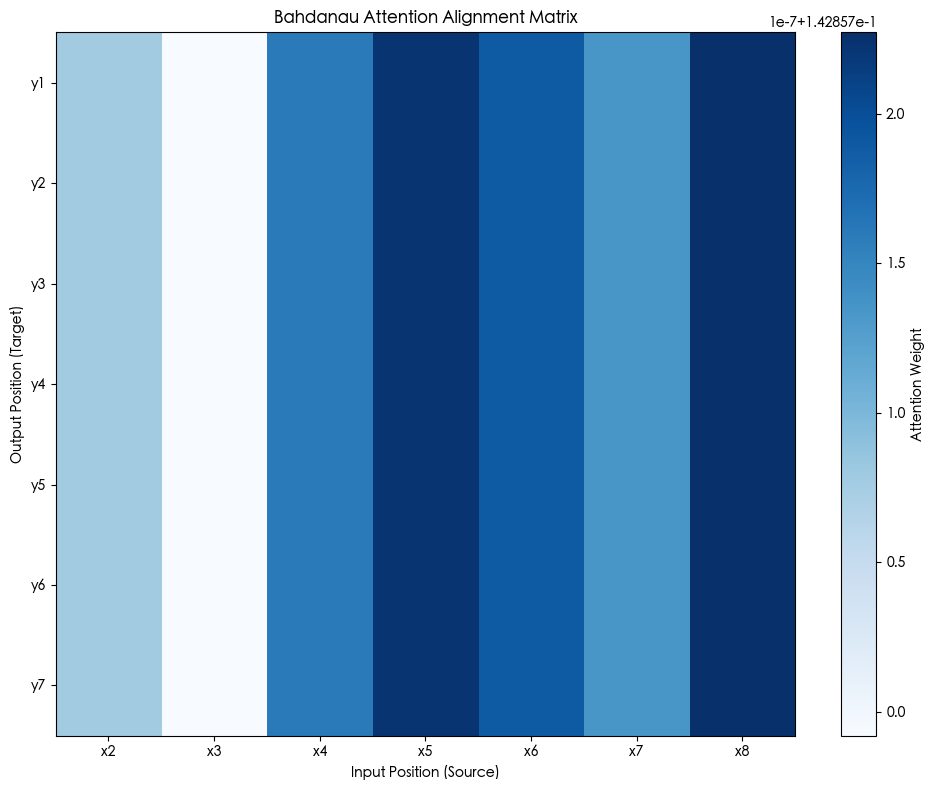


Attention patterns show which input positions influence each output.
Brighter cells = higher attention weight.


In [7]:
# Convert attention history to matrix
attention_matrix = np.array(attention_history)  # (output_len, input_len)

plt.figure(figsize=(10, 8))
plt.imshow(attention_matrix, cmap='Blues', aspect='auto', interpolation='nearest')
plt.colorbar(label='Attention Weight')
plt.xlabel('Input Position (Source)')
plt.ylabel('Output Position (Target)')
plt.title('Bahdanau Attention Alignment Matrix')

# Add grid
plt.xticks(range(len(input_seq)), [f'x{i+1}' for i in input_seq])
plt.yticks(range(len(outputs)), [f'y{i+1}' for i in range(len(outputs))])

plt.tight_layout()
plt.show()

print("\nAttention patterns show which input positions influence each output.")
print("Brighter cells = higher attention weight.")

## 每个解码步骤的注意力

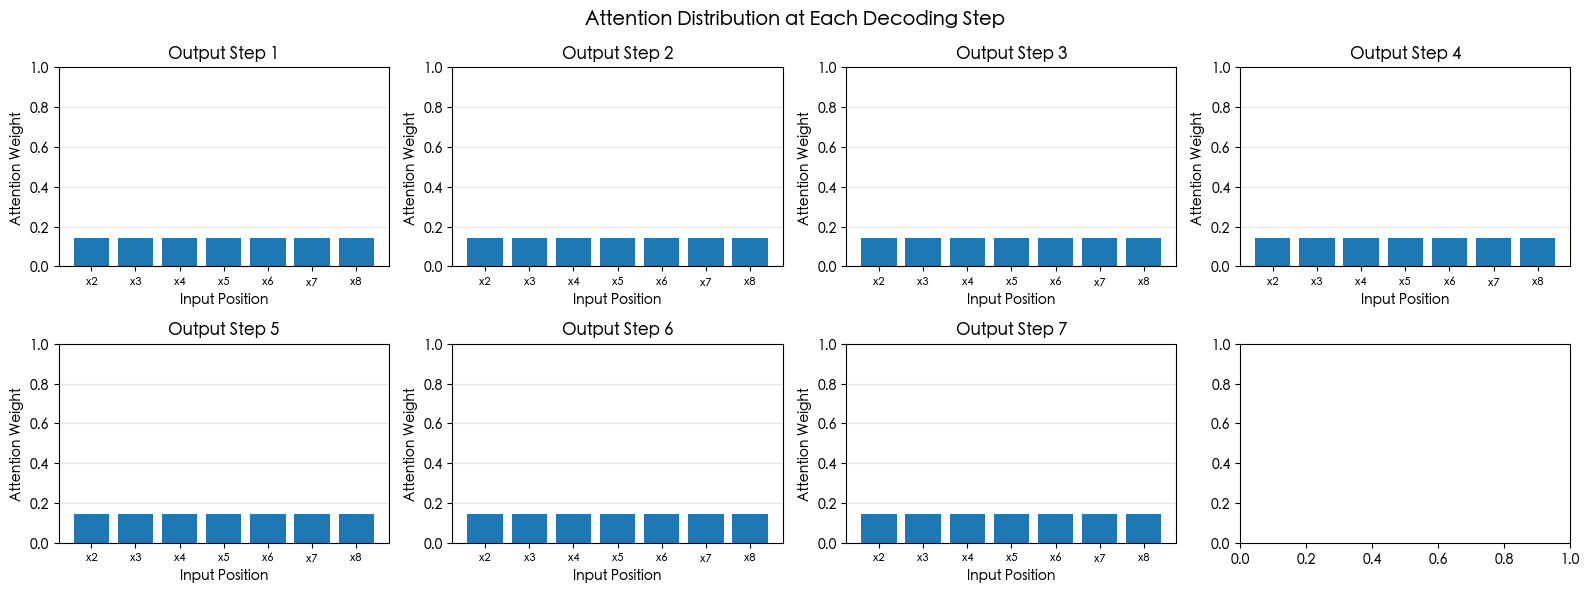

Each decoder step focuses on different input positions!


In [8]:
# Visualize attention distribution at specific decoder steps
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

steps_to_show = min(8, len(attention_history))

for i in range(steps_to_show):
    axes[i].bar(range(len(input_seq)), attention_history[i])
    axes[i].set_title(f'Output Step {i+1}')
    axes[i].set_xlabel('Input Position')
    axes[i].set_ylabel('Attention Weight')
    axes[i].set_ylim(0, 1)
    axes[i].set_xticks(range(len(input_seq)))
    axes[i].set_xticklabels([f'x{j+1}' for j in input_seq], fontsize=8)
    axes[i].grid(True, alpha=0.3, axis='y')

plt.suptitle('Attention Distribution at Each Decoding Step', fontsize=14)
plt.tight_layout()
plt.show()

print("Each decoder step focuses on different input positions!")

## 对比：有注意力 vs 无注意力

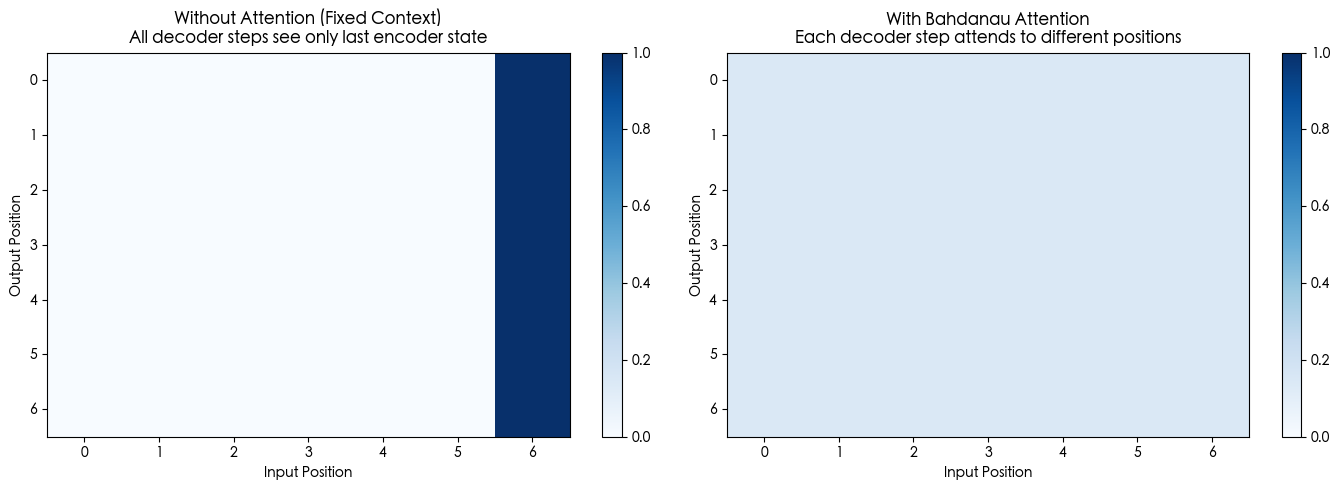


Key Difference:
  Without attention: Information bottleneck at last encoder state
  With attention: Dynamic access to all encoder states


In [9]:
# Simulate fixed-context seq2seq (no attention)
def fixed_context_attention(seq_len):
    """Simulates attending only to last encoder state"""
    weights = np.zeros(seq_len)
    weights[-1] = 1.0  # Only attend to last position
    return weights

# Create comparison
input_length = len(input_seq)
output_length = len(outputs)

# Fixed context
fixed_attention = np.array([fixed_context_attention(input_length) for _ in range(output_length)])

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Without attention (fixed context)
im1 = ax1.imshow(fixed_attention, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax1.set_xlabel('Input Position')
ax1.set_ylabel('Output Position')
ax1.set_title('Without Attention (Fixed Context)\nAll decoder steps see only last encoder state')
plt.colorbar(im1, ax=ax1)

# With Bahdanau attention
im2 = ax2.imshow(attention_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax2.set_xlabel('Input Position')
ax2.set_ylabel('Output Position')
ax2.set_title('With Bahdanau Attention\nEach decoder step attends to different positions')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\nKey Difference:")
print("  Without attention: Information bottleneck at last encoder state")
print("  With attention: Dynamic access to all encoder states")

## 注意力机制变体

In [10]:
def bahdanau_score(s, h, W_a, U_a, v_a):
    """Additive/Concat attention (Bahdanau)"""
    return np.dot(v_a.T, np.tanh(np.dot(W_a, s) + np.dot(U_a, h)))[0, 0]

def dot_product_score(s, h):
    """Dot product attention (Luong)"""
    return np.dot(s.T, h)[0, 0]

def scaled_dot_product_score(s, h):
    """Scaled dot product (Transformer-style)"""
    d_k = s.shape[0]
    return np.dot(s.T, h)[0, 0] / np.sqrt(d_k)

# Compare scoring functions
s = np.random.randn(16, 1)
h = np.random.randn(32, 1)
W_a = np.random.randn(16, 16)
U_a = np.random.randn(16, 32)
v_a = np.random.randn(1, 16)

print("Attention Score Functions:")
print(f"  Bahdanau (additive): score = v^T tanh(W*s + U*h)")
print(f"  Dot product: score = s^T h")
print(f"  Scaled dot product: score = s^T h / sqrt(d_k)")
print(f"\nBahdanau is more expressive but has more parameters.")

Attention Score Functions:
  Bahdanau (additive): score = v^T tanh(W*s + U*h)
  Dot product: score = s^T h
  Scaled dot product: score = s^T h / sqrt(d_k)

Bahdanau is more expressive but has more parameters.


## 关键要点

### 注意力解决的问题：
- **固定长度上下文**：整个输入压缩为单个向量
- **信息瓶颈**：长序列丢失信息
- **无对齐**：解码器不知道应该关注哪个输入

### Bahdanau 注意力创新：
1. **动态上下文**：每个解码步骤不同
2. **软对齐**：学习对齐源和目标
3. **所有编码器状态**：解码器可访问所有状态，而不仅仅是最后一个

### 工作原理：
```
1. 编码器产生标注 h_1, ..., h_T
2. 对于每个解码步骤 i：
   a. 计算注意力分数：e_ij = score(s_{i-1}, h_j)
   b. 归一化为权重：α_ij = softmax(e_ij)
   c. 计算上下文：c_i = Σ α_ij * h_j
   d. 生成输出：y_i = f(s_i, c_i, y_{i-1})
```

### Bahdanau vs Luong 注意力：
| 特性 | Bahdanau (2014) | Luong (2015) |
|---------|----------------|---------------|
| 分数 | 加性：v·tanh(W·s + U·h) | 乘性：s·h |
| 时机 | 使用 s_{i-1}（前一个） | 使用 s_i（当前） |
| 全局/局部 | 仅全局 | 两者皆有 |

### 数学公式：

**注意力分数（对齐模型）**：
$$e_{ij} = v_a^T \tanh(W_a s_{i-1} + U_a h_j)$$

**注意力权重**：
$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}$$

**上下文向量**：
$$c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j$$

**解码器**：
$$s_i = f(s_{i-1}, y_{i-1}, c_i)$$
$$p(y_i | y_{<i}, x) = g(s_i, y_{i-1}, c_i)$$

### 影响：
- **革命化了 NMT**：BLEU 分数显著提升
- **可解释性**：可以可视化对齐
- **Transformer 的基础**：纯注意力（2017）
- **超越 NMT**：用于视觉、语音等

### 为什么有效：
1. **解决瓶颈**：可变长度上下文
2. **学习对齐**：无需单独的对齐模型
3. **可微分**：端到端训练
4. **适用于长序列**：注意力不衰减

### 现代视角：
- Transformer 使用**自注意力**（关注同一序列）
- 缩放点积现在是标准（更简单、更快）
- 多头注意力捕获不同关系
- 但 Bahdanau 的核心思想仍然存在：**关注相关内容**

### 注意力机制的统一视角：

| 类型 | 查询 | 键 | 值 | 用途 |
|------|------|-----|-----|------|
| Bahdanau | Decoder state | Encoder states | Additive | 翻译 |
| Luong | Decoder state | Encoder states | Multiplicative | 翻译 |
| Self-Attn | All positions | All positions | Scaled dot | Transformer |
| Cross-Attn | Query | Keys, Values | Scaled dot | RAG, T5 |